In [2]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy import stats
from scipy import optimize
import numpy.random as random
import emcee
import corner
import random
from PyAstronomy import funcFit as fuf
from PyAstronomy import pyasl
from gaussfold import gaussfold as gf
from IPython.display import display, Math
from specutils.fitting import fit_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy.modeling import models
import multiprocessing as mp
Pool = mp.get_context('fork').Pool
from dust_extinction.parameter_averages import F19
# define the model
ext = F19(Rv=3.1)


plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9


whoami = 'andrewmann'

/Users/andrewmann/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

In [4]:
def resample_model(modelwave,modelspectra,igrinswave):
    #modelspec1 = doublespec(modelteff, modelspectra, 3540,2800,0.2)
    #modelspec2= doublespec(modelteff, modelspectra, 3540,2800,0.5)
    #modelspec3 = doublespec(modelteff, modelspectra, 3540,2800,0.8)
    #for ii in x:
    #    print(ii)
    #    igrinswave = igwave[ii,:]
    #    ll = np.where((modelwave > np.min(igrinswave))&(modelwave < np.max(igrinswave)))
    #    plt.plot(modelwave,modelspec3/np.median(modelspec3[ll]),label='80% spots',alpha=0.7)
    #    plt.plot(modelwave,modelspec2/np.median(modelspec2[ll]),label='50% spots',alpha=0.7)
    #    plt.plot(modelwave,modelspec1/np.median(modelspec1[ll]),label='20% spots',alpha=0.7)
    #    plt.xlim(np.min(igrinswave)+10,np.max(igrinswave)-10)
    #    plt.ylim(0.3,1.4)
    #    plt.legend()
    #    plt.show()

    ## resample model spectra
    from gaussfold import gaussfold as gf
    newlambda = np.array(igrinswave)
    newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
    for i in range(0,np.size(modelteff)):
        tmp = np.array(modelspectra[:,i])
        interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
        modelspec_new = interpfunc(newlambda)
        modelspec_new = gf(newlambda, modelspec_new, np.median(newlambda)/45000)
        newmodel[:,i] = modelspec_new

    modelspectra = newmodel
    modelwave = newlambda
    #modelspec = doublespec(modelteff, modelspectra, 3540,3520,0.01)
    #modelspec/=np.median(modelspec[np.where((modelwave > wrange[0])&(modelwave < wrange[1]))])
    #modelspec2 = doublespec(modelteff, modelspectra, 3540,2800,0.7)
    #modelspec2/=np.median(modelspec2[np.where((modelwave > wrange[0])&(modelwave < wrange[1]))])
    #plt.plot(modelwave,modelspec,alpha=0.5,label='nospot')
    #plt.plot(modelwave,modelspec2,alpha=0.5,label='spot')
    #plt.xlim(wrange[0],wrange[1])
    #plt.ylim(0.5,1.2)
    #plt.legend()
    #plt.show()
    return modelspectra, modelwave



/Users/andrewmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


3145922.550482513 184509.06650942712 14622.652728133173 291616.12 14500.050000000001


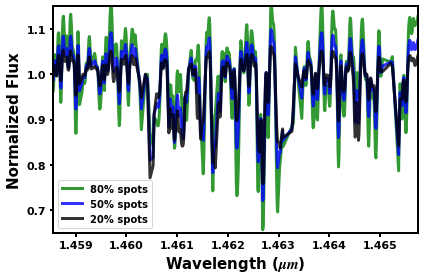

In [5]:
trim = 35
hdul = fits.open('SDCH_20170316_0102.spec_a0v.fits')
hdr = hdul[1].header
data = hdul[1].data
hdul2 = fits.open('SDCH_20170316_0102.variance.fits')
data2 = hdul2[0].data

igspec_diva0 = hdul[0].data
igwave = hdul[1].data*1e4
igspec = hdul[2].data
igspec_a0 = hdul[3].data
igspec_vega = hdul[4].data
igspec_dividecont = hdul[5].data
fracerr = (np.sqrt(data2/igspec**2 + igspec_a0/igspec_a0**2))
snr = 1./fracerr
norders = np.size(snr[:,0])

modelpath = '/Users/andrewmann/Dropbox/Radii/Models_K233_Feb2020.fits'
hdul = fits.open(modelpath)
hdr = hdul[1].header
data = hdul[1].data
lambda0 = 4000
nlambda = 210001
dlambda = 0.1
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
modelteff = np.squeeze(data['teff'])
modellogg = np.squeeze(data['logg'])
modelafe = np.squeeze(data['a_fe'])
modelmh = np.squeeze(data['metal'])
modelspectra = np.squeeze(data['spectrum'])

order = 25#7
wrange = [np.min(igwave[order,:])+trim,np.max(igwave[order,:])-trim]
igrinswave = np.array(igwave[order,:])
igrinsspec = np.array(igspec_diva0[order,:])
igrinserr = np.array(igrinsspec*fracerr[order,:])
tmp = igrinsspec/np.nanmedian(igrinsspec)
ll = np.where((np.isfinite(igrinserr))&(np.isfinite(igrinswave))&(np.isfinite(igrinsspec))&(igrinserr>0)&(tmp<1.2))
igrinsspec = np.squeeze(igrinsspec[ll])
igrinserr = np.squeeze(igrinserr[ll])
igrinswave = np.squeeze(igrinswave[ll])
ll = np.where((igrinswave > wrange[0])&(igrinswave < wrange[1]) )
igrinsspec = igrinsspec[ll]
igrinserr = igrinserr[ll]
igrinswave = igrinswave[ll]

print(np.median(igrinsspec),np.median(igrinserr),np.median(igrinswave),np.nanmedian(modelspectra),np.median(modelwave))

modelspectra, modelwave = resample_model(modelwave,modelspectra,igrinswave) 
            
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

alpha = 0.8
## here let's make some example spectra to show off why this method works
spec3 = doublespec(modelteff,modelspectra,3540,2800,0.8)
plt.plot(modelwave/1e4,spec3/np.median(spec3),label='80% spots',alpha=alpha,color='green')
spec2 = doublespec(modelteff,modelspectra,3540,2800,0.5)
plt.plot(modelwave/1e4,spec2/np.median(spec2),label='50% spots',alpha=alpha,color='blue')
spec1 = doublespec(modelteff,modelspectra,3540,2800,0.2)
plt.plot(modelwave/1e4,spec1/np.median(spec1),label='20% spots',alpha=alpha,color='black')

plt.tight_layout
ax.set_xlim(np.min(modelwave/1e4)+0.003,np.max(modelwave/1e4)-0.003)
#plt.xscale('log')
#plt.yscale('log')
#ax.set_ylim(np.min(spec3/np.median(spec3)),np.max(spec3/np.median(spec3)))
ax.set_ylim(0.65,1.15)
plt.legend()
ax.set_ylabel(r'Normalized Flux')
ax.set_xlabel(r'Wavelength ($\mu m$)')
plt.tight_layout()
plt.savefig('Example_spots_highres'+str(order)+'.pdf')


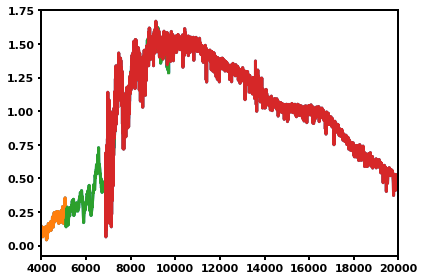

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 44252296E, 296E, 296E, 296E, 296E, 296E]   


In [6]:
obswav,obsspec,obserr,obstype = np.loadtxt('rawspec.txt',unpack=True,skiprows=1)

plt.plot(obswav,obsspec)
l1 = np.where(obstype == 1)
plt.plot(obswav[l1],obsspec[l1])
l2 = np.where(obstype == 2)
plt.plot(obswav[l2],obsspec[l2])
l3 = np.where(obstype == 3)
plt.plot(obswav[l3],obsspec[l3])
plt.xlim(4000,20000)
plt.tight_layout()
plt.show()

## this trims the bad region of the SpeX data (noisy)
l4 = np.where((obswav > 4000) & (obswav<24000) & ((obswav > 8000)|(obstype<3)) & (obsspec > 0))
opticalspec = obsspec[l4]
opticalwav = obswav[l4]
opticalerr = obserr[l4]
l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 10))
#if mask_optical: ## if we want to cut the annoying region around 6300-6600
#    l5 = np.where((obswav > 4000) & (obswav<23500) & (obsspec/obserr > 15) & ((obswav > 6600)|(obswav<6350)) & ((obswav > 6153)|(obswav<6056)) & ((obswav > 7020)|(obswav<6915)) & ((obswav > 7580)|(obswav<7700))   )
#if nir_only:
#    l5 = np.where((obstype == 3)&(obswav<23500))
#if optical_only:
#    l5 = np.where((obstype < 3)&(obswav > 4000))
#if optical_only & mask_optical:
#    l5 = np.where((obstype<3) & (obswav > 4000) & (obswav<23500) & (obsspec/obserr > 15) & ((obswav > 6600)|(obswav<6350)) & ((obswav > 6153)|(obswav<6056)) & ((obswav > 7020)|(obswav<6915)) & ((obswav > 7580)|(obswav<7700))   )

obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])

modelpath = '/Users/'+whoami+'/Dropbox/Radii/Models_CIFIST_Dupuy.fits'
lambda0 = 1000
nlambda = 149501
dlambda = 2
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
## trim the models to just solar metallicity and log(g) = 4.5
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
modelteff = np.squeeze(data['teff'])
modellogg = np.squeeze(data['logg'])
modelafe = np.squeeze(data['a_fe'])
modelmh = np.squeeze(data['metal'])
modelspectra = np.squeeze(data['spectrum'])

modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
ll = np.where((modelwave > 3000) & (modelwave < 53000))
modelspectra = np.squeeze(modelspectra[ll,:])
modelwave = modelwave[ll]

## resample model spectra to match input data
newlambda = np.array(obswav_cut)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc(newlambda)
    ## not quite right. 5-10A is OK for optical (R~1000), but NIR should be R~2000 (10 at 10000 and 20 at 20000)
    ## tests indicate this is not a serious problem
    modelspec_new = gf(newlambda, modelspec_new, 8) 
    newmodel[:,i] = modelspec_new

modelwave = newlambda
modelspectra = newmodel

In [16]:
## find priors on the slope parameters
for obstype in [1,2,3]:
    tmp1 = obswav_cut[np.where(obstype_cut == obstype)]
    diff = np.max(tmp1-np.mean(tmp1)) - np.min(tmp1-np.mean(tmp1))
    #print(diff)
    b = 0.03/diff
    print(b)

3.7956906259093845e-05
6.5364888596441545e-06
1.8461356688180301e-06


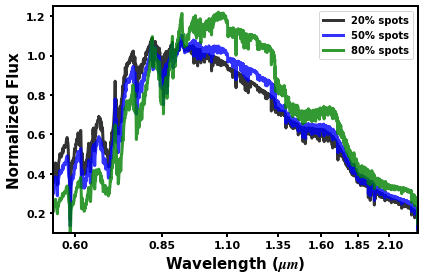

<Figure size 432x288 with 0 Axes>

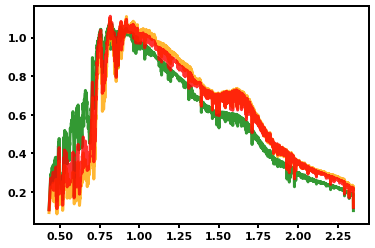

In [6]:
from matplotlib.ticker import ScalarFormatter
obsspec_cut = np.array(obsspec[l5])
obswav_cut = np.array(obswav[l5])
obserr_cut = np.array(obserr[l5])
obstype_cut = np.array(obstype[l5])

ospec = np.array(list(obsspec_cut))
otype = np.array(list(obstype_cut))
oerr = np.array(list(obserr_cut))
mspec = np.array(list(modelspectra))
mteff = np.array(list(modelteff))
mwav = np.array(list(modelwave))

### do not delete, this needs to be transfered to the other notebook
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

alpha = 0.8
# here let's make some example spectra to show off why this method works
modelwave = obswav_cut
#norm = np.where((modelwave < 8000)&(modelwave>7000))
nowm_wrange = [0.7,1.1]
visible_range = [0.55,2.35]
norm = np.where((modelwave > nowm_wrange[0]*1e4)&(modelwave<nowm_wrange[1]*1e4))
spec1 = doublespec(modelteff,modelspectra,3540,2800,0.2)
#print(np.sum(spec1/np.nanmedian(spec1[norm])))
plt.plot(modelwave/1e4,spec1/np.nanmedian(spec1[norm]),label='20% spots',alpha=alpha,color='black')

spec2 = doublespec(modelteff,modelspectra,3540,2800,0.5)
#print(np.sum(spec2/np.nanmedian(spec2[norm])))
plt.plot(modelwave/1e4,spec2/np.nanmedian(spec2[norm]),label='50% spots',alpha=alpha,color='blue')

spec3 = doublespec(modelteff,modelspectra,3540,2800,0.8)
#print(np.sum(spec3/np.nanmedian(spec3[norm])))
plt.plot(modelwave/1e4,spec3/np.nanmedian(spec3[norm]),label='80% spots',alpha=alpha,color='green')



ax.set_xlim(visible_range[0],visible_range[1])
ax.set_ylim(0.1,1.25)
plt.xscale('log')
plt.legend()
ax.set_ylabel(r'Normalized Flux')
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.minorticks_off()
ax.set_xticks(np.arange(0.6,2.35,step=0.25))
#ax.set_xticks([0.60,0.85,1.20,1.65,2.30])
plt.tight_layout()

plt.savefig('Example_spots_lowres.pdf')
plt.show()

plt.clf()
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
spec4 = getspec(modelteff,modelspectra,3540)
plt.plot(modelwave/1e4,spec4/np.nanmedian(spec4[norm]),label='1% spots',alpha=alpha,color='green')
spec5 = getspec(modelteff,modelspectra,3400)
plt.plot(modelwave/1e4,spec5/np.nanmedian(spec5[norm]),label='1% spots',alpha=alpha,color='orange')

spec6 = doublespec(modelteff,modelspectra,3540,3500,0.9)
plt.plot(modelwave/1e4,spec6/np.nanmedian(spec6[norm]),label='80% spots, T=3500',alpha=alpha,color='red')
plt.show()
#print((np.logspace(np.log10(0.6),np.log10(2.3),num=5)))


Transit fit stuff

In [7]:
def to_str(var):
    if type(var) is list:
        return str(var)[1:-1] # list
    if type(var) is np.ndarray:
        try:
            return str(list(var[0]))[1:-1] # numpy 1D array
        except TypeError:
            return str(list(var))[1:-1] # numpy sequence
    return str(var) # everything else

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 44252296E, 296E, 296E, 296E, 296E, 296E]   
(29,) (10400, 29) (10400,)
3900.0 1100.0
HST2
dict_keys(['name', 'wl_min', 'wl_max'])
HST1 11123.43451781227
HST2 11864.16574686992
HST3 12603.32803339265
HST4 13341.324624064548
HST5 14083.264182111676
HST6 14825.503397490855
HST7 15565.710363153057
HST8 16305.563257737362
mearth 7998.826002382366
Kepler 6485.232194341037
S1 34217.64790815103
S2 43131.32761141984


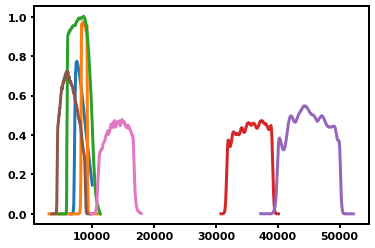

In [8]:
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Dupuy.fits' ## these models go a bit cooler. 
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
teff = np.squeeze(data['teff'])
logg = np.squeeze(data['logg'])
afe = np.squeeze(data['a_fe'])
mh = np.squeeze(data['metal'])
spectra = np.squeeze(data['spectrum'])
loc = np.where((logg == 4.5) & (mh == 0) & (teff > 1000) & (afe == 0))
modelteff = teff[loc]
modelspectra = np.squeeze(spectra[:,loc])
lambda0 = 1000
nlambda = 149501
dlambda = 2
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
ll = np.where((modelwave > 3400) & (modelwave < 53000))
modelspectra = np.squeeze(modelspectra[ll,:])
modelwave = modelwave[ll]
lambda0 = 3000
nlambda = int((55000-3000)/5)
dlambda = 10
## resample model spectra
newlambda = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    interpfunc1 = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc1(newlambda)
    modelspec_new = gf(newlambda, modelspec_new, 20)
    newmodel[:,i] = modelspec_new

modelwave = newlambda
modelspectra = newmodel

print(np.shape(modelteff),np.shape(modelspectra),np.shape(modelwave))
print(np.max(modelteff),np.min(modelteff))

from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
x,y = np.genfromtxt('filters/mearth.tsv', delimiter=';', unpack=True)
x*=10
plt.plot(x,y, label='MEarth')
mearth = TabulatedFilter('mearth', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/pstr-zs-avg.txt', unpack=True)
x*=10
plt.plot(x,y, label='zs')
zs = TabulatedFilter('zs', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/tess-response-function-v1.0.csv', unpack=True, comments='#', delimiter=',')
x*=10
plt.plot(x,y, label='tess')
tess = TabulatedFilter('tess', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch1trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp1')
s1 = TabulatedFilter('S1', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch2trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp2')
s2 = TabulatedFilter('S2', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/Kepler_Kepler.K.dat', unpack=True, comments='#', delimiter=',')
#x/=10
plt.plot(x,y, label='Kepler')
kepler = TabulatedFilter('Kepler', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/HST_WFC3_IR.G141.dat', unpack=True, comments='#', delimiter=' ')
#x/=10
plt.plot(x,y, label='G141')
G141 = TabulatedFilter('G141', x[np.isfinite(y)], y[np.isfinite(y)])

## HST bands
b1 = [11108,11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042]
b2 = [11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042,16432]
b1 = [11108,11773.5,12439,13104.5,13770,14435.5,15101,15766.5]
b2 = [11773.5,12439,13104.5,13770,14435.5,15101,15766.5,16432]
nbins = 8
tmp = np.linspace(10880,16800,nbins+1)
b1 = np.round(tmp[0:nbins])
b2 = np.round(tmp[1:nbins+1])
b1_num = np.array(b1)#/10
b2_num = np.array(b2)#/10
HST_bands = []
hst_names = np.array(b1,dtype=str)
for i in range(0,np.size(b1)):
    str1 = (to_str(round(b1[i])))
    str2 = (to_str(round(b2[i])))
    hst_names[i] = str(str1)+'--'+str(str2)         
counter = 1
for i,j in zip(b1_num,b2_num):
    HST_bands.append(BoxcarFilter('HST'+str(counter),i,j))
    counter=counter+1

    
#print(HST_bands)
filters = HST_bands
filters.append(mearth)
filters.append(kepler)
filters.append(s1)
filters.append(s2)
print(filters[1].name)
fnames = []
for i in range(0,np.size(filters)):
    fnames = np.append(fnames,filters[i].name)
## wl (double-u el) and tm
filters[10].__dict__.keys()
#filters[0].name
#names
#print(G141.tm)
inc = np.squeeze(np.where(fnames == 'HST1'))
print(filters[inc].__dict__.keys())
hasattr(filters[inc],'wl_max')


from scipy import integrate
## get out the wavelengths for each:
star = getspec(modelteff,modelspectra,3470)

leffs = []
for i in range(0,np.size(filters)):
    filt = filters[i]
    if hasattr(filt,'wl'):
        fw = filt.wl
        tm = filt.tm
    else:
        fw = np.arange(filt.wl_min,filt.wl_max,1)
        tm = fw*0+1.
    interpfunc = interpolate.interp1d(modelwave, star, kind='linear')
    interpolflux = interpfunc(fw)
    leff = np.sum(integrate.cumtrapz(fw*tm*interpolflux,fw))/np.sum(integrate.cumtrapz(tm*interpolflux,fw))
    print(filt.name,leff)
    leffs.append(leff)

0.001269


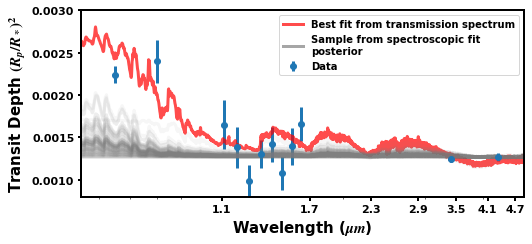

In [13]:
filename = 'Lowres_backend2.h5'#'Lowres_backend2.h5'
reader = emcee.backends.HDFBackend(filename)
burnin = 10000
thin = 5
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)


import matplotlib.ticker
fig, ax = plt.subplots()
fig.set_size_inches(7.5, 3.5)

leffs = np.array(leffs)
depth, errp, errm = np.loadtxt('bins_result_run46.dat',unpack=True,skiprows=1)
plt.errorbar(leffs/10000, depth, yerr=[errm,errp], fmt='o',label='Data')
             
## plot the best fit (take these values from the other notebook)
#6.85382043e+01 2.73158722e+03 9.00768197e-04
Tspot = 2.73158722e+03
D = 9.00768197e-04
fS = 6.85382043e-1
spot = getspec(modelteff,modelspectra,Tspot)
surf = getspec(modelteff,modelspectra,3480)
star = surf*(1.-fS) + spot*fS
outoftransit = star
intransit = (surf-surf*(D/(1.-fS)))*(1.-fS) + spot*fS
transit = (outoftransit-intransit)/outoftransit
plt.plot(modelwave/10000,transit,label='Best fit from transmission spectrum',alpha=0.7,color='red')
             
spotfracs = samples[:,2]
tspots = samples[:,1]
tsurfs = samples[:,0]
D = 0.001269
ll = np.where((modelwave/10000 > 4.4)&(modelwave/10000 < 4.6))
dd = depth[np.size(depth)-1]
print(dd)
for i in range(100):
    ## pull out a random sample of Tspot, Tsurf, and fS
    Tsurf = random.choice(tsurfs)
    fS = random.choice(spotfracs)
    Tspot = random.choice(tspots)
    spot = getspec(modelteff,modelspectra,Tspot+75)
    surf = getspec(modelteff,modelspectra,Tsurf+75)
    star = surf*(1.-fS) + spot*fS
    outoftransit = star
    intransit = (surf-surf*(D/(1.-fS)))*(1.-fS) + spot*fS
    transit = (outoftransit-intransit)/outoftransit
    ##print(transit[ll])
    norm1 = np.mean(transit[ll])
    norm2 = norm1/dd
    #print(norm1,norm2)
    transit/=norm2
    if i == 1:
        plt.plot(modelwave/10000,transit*1e5,alpha=0.7,color='grey',label='Sample from spectroscopic fit\nposterior')
    else:
        plt.plot(modelwave/10000,transit,alpha=0.07,color='grey')
    
plt.xscale('log')
plt.xticks([0.6, 0.9, 1.3, 2.0, 3.1, 4.6],labels=['0.6', '0.9', '1.1','2.0', '3.1', '4.6'])
plt.xticks([0.5, 1.1, 1.7, 2.3, 2.9, 3.5, 4.1, 4.7],labels=['0.5', '1.1', '1.7', '2.3', '2.9', '3.5', '4.1', '4.7'])
#locs, labels = plt.xticks() 
ax.set_ylabel(r'Transit Depth $(R_p/R_*)^2$')
ax.set_xlabel(r'Wavelength ($\mu m$)')
plt.legend()
ax.set_xlim(0.55,4.9)
ax.set_ylim(0.0008,0.003)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.tight_layout()
#ax.set_aspect(200.0)
plt.savefig('Transspec_spots_samples.pdf')
